# 📈 Case Study – Predicting Yahoo Stock Prices (Chapter 3)

## 🧠 Business Context

**🧑‍💼 Characters:**
- David: Financial analyst or advisor, with strong academic background (Harvard Business School).
- Janice: High-net-worth individual, investor, daughter of a millionaire businessman.

**📉 Business Context:**
- Janice made **high-risk, long-term investments** due to positive market expectations.
- Despite a favorable market, she **experienced a dip** in returns this quarter.
- David’s investigation showed the **dip was largely due to inaccuracies** in **Yahoo stock forecasts.**

---

## 🔍 Problem Statement

David discovered that the **Yahoo stock forecasts had large residual errors**, i.e., the difference between the actual stock value and the predicted value was significant.

> This would be acceptable if Yahoo stock was a small portion of the portfolio.  
> But since it was a **major holding**, this **forecast error greatly impacted total returns**.

---

## ❓ Key Questions

- What caused the **large residuals** in Yahoo’s stock forecast?
- Can the **forecasting method be improved**?
- Should David use **regression** or **time series** modeling?
- What specific **techniques or models** are suitable for such forecasting?

---

## 🧪 Chosen Approach: Time Series Modeling

David recalled concepts from his finance and analytics courses and chose **Time Series Analysis** as the right approach.

- Stock prices are sequential → need to model temporal dependencies.
- **ARIMA** (Auto-Regressive Integrated Moving Average) will be used for modeling.
- Forecasting accuracy will be evaluated and improved.

---

## 📊 Dataset Description

David pulled Yahoo’s stock price data using the `matplotlib.finance` Python package.

### Data Dictionary

| Feature      | Description                                   |
|--------------|-----------------------------------------------|
| `Date`       | Date of the stock record                      |
| `Open`       | Opening price of the stock on that date       |
| `High`       | Highest price of the stock on that date       |
| `Low`        | Lowest price of the stock on that date        |
| `Close`      | Closing price of the stock on that date       |
| `Volume`     | Number of shares traded on that day           |
| `Adj Close`  | Adjusted close price (used for time series)   |

---

## 🎯 Objective

To build a **time series forecasting model** for Yahoo stock using historical adjusted closing prices, in order to:

- Understand patterns like **trend, seasonality, and stationarity**
- Select the best model parameters (p, d, q)
- Generate **more accurate future predictions**
- Reduce forecast error in Janice's portfolio

---

> ✅ The next step is to begin **feature exploration** and assess the stationarity of the series before modeling.


### Listing 3-1. Importing Packages Required for This Chapter

In [122]:
# Enable inline plotting in Jupyter Notebook
%matplotlib inline

# Core libraries
import pandas as pd
import numpy as np
from datetime import datetime

# Visualization
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = (15, 5)

# Statsmodels for Time Series Analysis
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA  # Modern ARIMA class (updated)

# Scikit-learn for regression and metrics
from sklearn.linear_model import LinearRegression
from sklearn.metrics import explained_variance_score

# Use yfinance to fetch Yahoo stock data
import yfinance as yf


##### Feature Exploration
David started off by loading the data into memory. 

### Listing 3-2. Reading the Data in the Memory


In [123]:


ticker_symbol = "^GSPC"  # This is the Yahoo symbol for S&P 500

start_date = "2016-01-01"
end_date = "2016-12-31"

yahoo_data = yf.download(ticker_symbol, start=start_date, end=end_date ,auto_adjust=False )

yahoo_data.head()

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC
Date,,,,,,
2016-01-04,2012.660034,2012.660034,2038.199951,1989.680054,2038.199951,4304880000
2016-01-05,2016.709961,2016.709961,2021.939941,2004.170044,2013.780029,3706620000
2016-01-06,1990.260010,1990.260010,2011.709961,1979.050049,2011.709961,4336660000
2016-01-07,1943.089966,1943.089966,1985.319946,1938.829956,1985.319946,5076590000
2016-01-08,1922.030029,1922.030029,1960.400024,1918.459961,1945.969971,4664940000


### Listing 3-3. Plotting Adjusted Closing Rate of Yahoo Stock for 2016 on a Time Series

#### 🎯 Goal:

To **visualize the Adjusted Closing Rate of Yahoo stock throughout 2016** in the form of a time series.  
This helps us observe trends and seasonality in the data.

David also intends to:
- **Split the dataset** into training (Jan–Sep) and testing (Oct–Dec) subsets.
- Use the **training set to build the model** and **testing set for validation**.


In [124]:
type(yahoo_data)
yahoo_data.columns

MultiIndex([('Adj Close', '^GSPC'),
            (    'Close', '^GSPC'),
            (     'High', '^GSPC'),
            (      'Low', '^GSPC'),
            (     'Open', '^GSPC'),
            (   'Volume', '^GSPC')],
           names=['Price', 'Ticker'])

In [125]:
# ✅ Flatten the MultiIndex columns

yahoo_data.columns = [col[0] for col in yahoo_data.columns]
# ✅ Convert index to datetime
yahoo_data.index = pd.to_datetime(yahoo_data.index)

# ✅ Preview the cleaned dataset
yahoo_data.head()

,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2016-01-04,2012.660034,2012.660034,2038.199951,1989.680054,2038.199951,4304880000
2016-01-05,2016.709961,2016.709961,2021.939941,2004.170044,2013.780029,3706620000
2016-01-06,1990.260010,1990.260010,2011.709961,1979.050049,2011.709961,4336660000
2016-01-07,1943.089966,1943.089966,1985.319946,1938.829956,1985.319946,5076590000
2016-01-08,1922.030029,1922.030029,1960.400024,1918.459961,1945.969971,4664940000


In [126]:
yahoo_data.columns

Index(['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'], dtype='object')

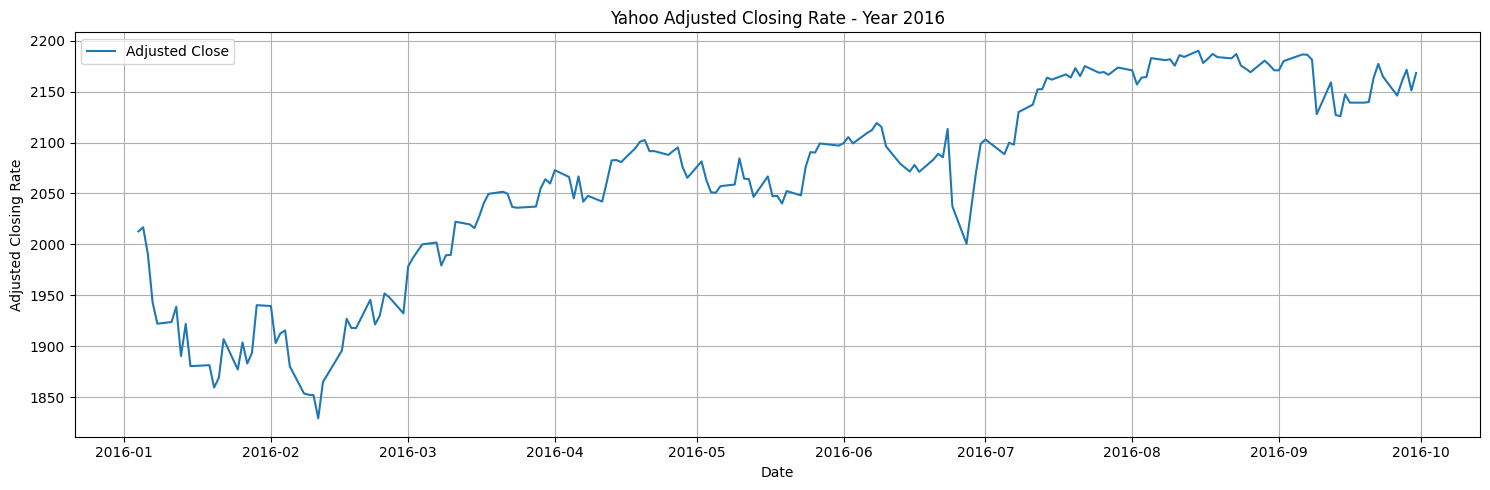

In [127]:
date_thresh = datetime.strptime('2016-10-01', "%Y-%m-%d").date()

data = yahoo_data[['Adj Close']].copy()

data_train = data[data.index.date < date_thresh]
data_test = data[data.index.date >= date_thresh]

plt.plot(data_train.index, data_train['Adj Close'], label="Adjusted Close")
plt.xlabel('Date')
plt.ylabel('Adjusted Closing Rate')
plt.title('Yahoo Adjusted Closing Rate - Year 2016')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Summary / Insight:

- The **plot shows an overall upward trend** in Yahoo's adjusted stock price during 2016.
- A **seasonal pattern** is also visible, with a noticeable **dip occurring approximately every 4–5 months**.
- This confirms the time series has **both trend and seasonality**, making it a strong candidate for **time series forecasting models** like ARIMA or SARIMA.
- Data is now **split into training (Jan–Sep)** and **testing (Oct–Dec)**, ready for model formulation and validation.

David will now proceed to model this time series using ARIMA and other tools to forecast and reduce prediction error in Janice’s portfolio.


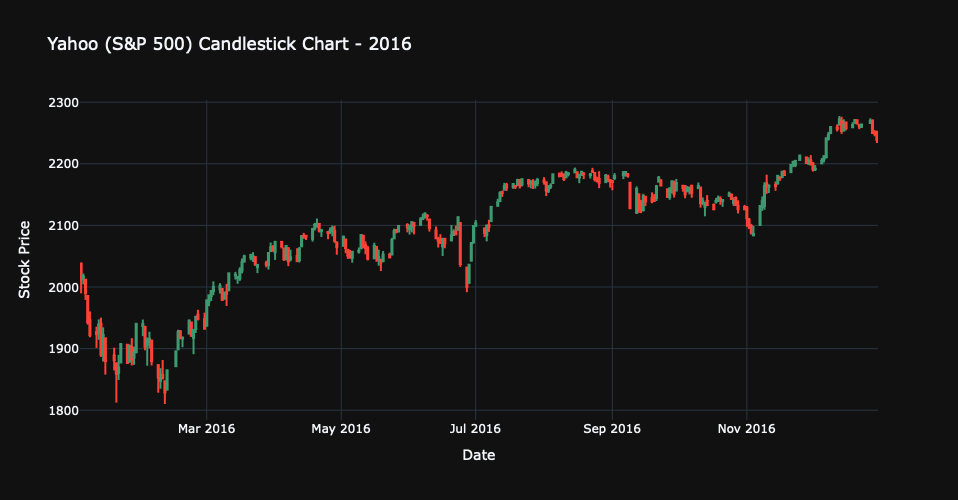

In [128]:
import plotly.graph_objects as go

# Use OHLC data for candlestick chart
fig = go.Figure(data=[go.Candlestick(
    x=yahoo_data.index,
    open=yahoo_data['Open'],
    high=yahoo_data['High'],
    low=yahoo_data['Low'],
    close=yahoo_data['Close']
)])

fig.update_layout(
    title='Yahoo (S&P 500) Candlestick Chart - 2016',
    xaxis_title='Date',
    yaxis_title='Stock Price',
    xaxis_rangeslider_visible=False,
    template='plotly_dark',
    width=1000,  # Adjust width (e.g., 800–1200 px)
    height=500   # Adjust height

)

fig.show()


### Listing 3-4. Method to Evaluate If a Time Series Object Is Stationary

#### Goal:
David wants to check if the **Yahoo Adjusted Closing Price time series** is **stationary** — meaning its statistical properties like **mean and variance remain constant over time**.

He does this using:
- **Rolling statistics** (mean and std dev)
- **Augmented Dickey-Fuller (ADF) test**

He also wraps it in a reusable function called `evaluate_stationarity()`, with a default window size of 30 days.


In [129]:

def evaluate_stationarity(timeseries, t=30):
    """
    Plots rolling statistics and performs Dickey-Fuller test to evaluate stationarity.
    
    Parameters:
    timeseries (pd.Series): The time series to evaluate.
    t (int): Rolling window size (default is 30 days).
    """
    # Rolling statistics
    rolmean = timeseries.rolling(window=t).mean()
    rolstd = timeseries.rolling(window=t).std()

    # Plot rolling mean and std dev
    plt.figure(figsize=(12, 5))
    plt.plot(timeseries, color='blue', label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label='Rolling Std Dev')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.grid(True)
    plt.show()

    # Perform Dickey-Fuller test
    print("\n Results of Augmented Dickey-Fuller Test:")
    dftest = adfuller(timeseries.dropna(), autolag='AIC')

    # Summary results
    dfoutput = pd.Series(dftest[0:4], index=[
        'Test Statistic', 'p-value', '# Lags Used', 'Number of Observations Used'
    ])
    for key, value in dftest[4].items():
        dfoutput[f'Critical Value ({key})'] = value

    print(dfoutput)


### Listing 3-5: Call the Stationarity Function

David now applies the `evaluate_stationarity()` function to the `Close_Adj` column from the Yahoo stock data.

He sets the window `t=15`, which approximates 2 weeks of trading days.


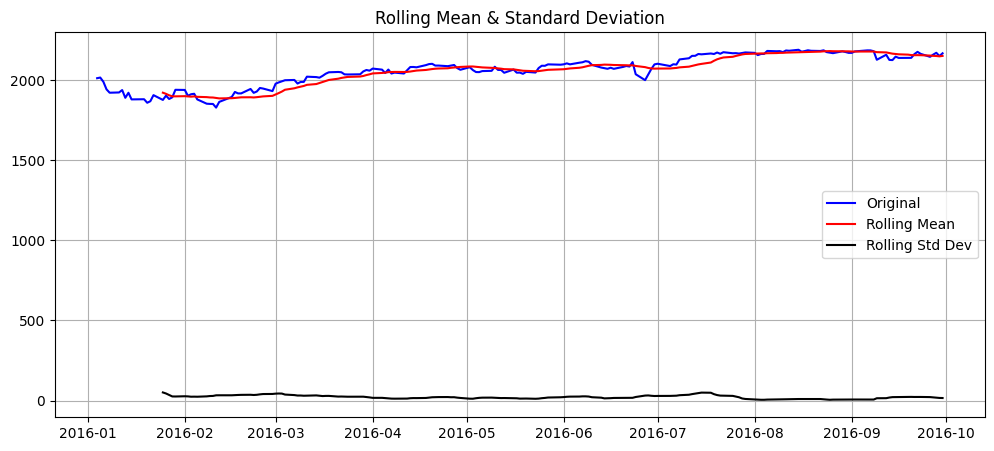


 Results of Augmented Dickey-Fuller Test:
Test Statistic                  -1.114302
p-value                          0.709335
# Lags Used                      0.000000
Number of Observations Used    188.000000
Critical Value (1%)             -3.465620
Critical Value (5%)             -2.877040
Critical Value (10%)            -2.575032
dtype: float64


In [130]:
# Call the function on the Adjusted Close price
evaluate_stationarity(data_train['Adj Close'], t=15)

### 📈 Interpretation

- The **blue curve** shows the original Yahoo Adjusted Closing Price.
- The **red line (rolling mean)** and **black line (rolling std dev)** give us a visual way to judge whether the series is stationary.

#### Dickey-Fuller Test Result:
- **p-value < 0.05** → reject the null hypothesis → the series is **stationary**.
- **p-value ≥ 0.05** → fail to reject the null → the series is **non-stationary**.

> A **stationary series** is ideal for applying models like ARIMA.  
> If the series is not stationary, we may need to **difference** it before modeling.

### 📖 What It Means

- The **null hypothesis** in the Augmented Dickey-Fuller (ADF) test is that the time series is **non-stationary**.
- The **p-value** is **0.7093**, which is **much greater than 0.05**, so:
  > 🔴 We **fail to reject** the null hypothesis.  
  > 🔍 This means the series is **non-stationary** — it likely has a **trend or seasonality**.

- The **Test Statistic** is **-1.1143**, which is **not less** than any of the critical values at 1%, 5%, or 10%.  
  This also confirms that the series is **not stationary**.

---

### 🔍 Listing 3-6. Applying Log Transformation to Time Series Object

#### 🎯 Goal:
David applies a **log transformation** to the Adjusted Closing Price of Yahoo stock.

- Log transformations **compress large values** and help **stabilize variance**, especially in financial time series.
- He hopes this transformation will help the series pass the


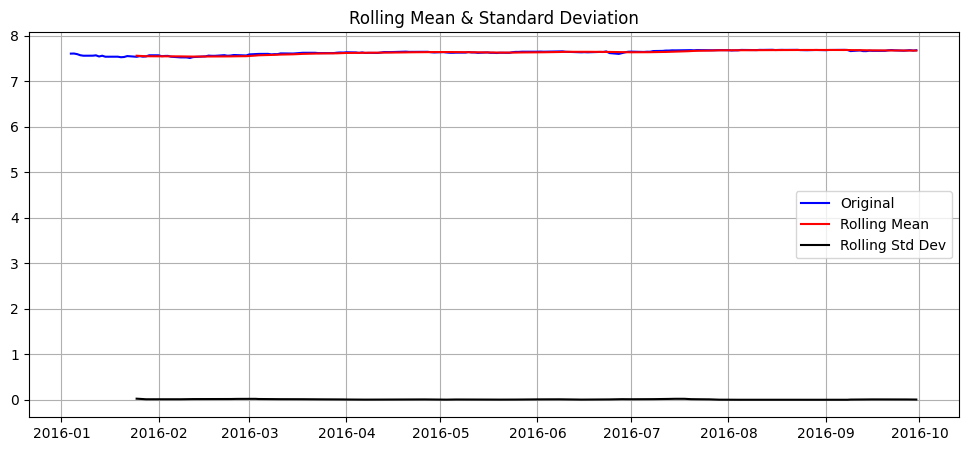


 Results of Augmented Dickey-Fuller Test:
Test Statistic                  -1.136109
p-value                          0.700460
# Lags Used                      0.000000
Number of Observations Used    188.000000
Critical Value (1%)             -3.465620
Critical Value (5%)             -2.877040
Critical Value (10%)            -2.575032
dtype: float64


In [131]:
# ✅ Apply log transformation to stabilize variance
data_log = np.log(data_train['Adj Close'])

# ✅ Re-evaluate stationarity
evaluate_stationarity(data_log, t=15)

###  Interpretation of Log-Transformed Series 

- ✅ **Visual Analysis**:
  - The **rolling mean and standard deviation** appear more **flat** compared to the original series.
  - Indicates a **possible improvement in stationarity**.

- ❌ **Dickey-Fuller Test**:
  - The **test statistic > critical values**, and **p-value ≥ 0.05**.
  - This means the **series is still not statistically stationary**.
  - The null hypothesis (non-stationarity) **cannot be rejected**.

### 🤔 Why is there a contradiction?

- Rolling mean/variance looks stable, but **subtle fluctuations** might still exist.
- Visual methods are **approximate**, while ADF is **statistical and stricter**.
- David decides to explore other techniques or add further transformations (e.g., differencing) next.



### Listing 3-7: Zooming In on Rolling Mean of Log-Transformed Series

#### Goal:
Although the **rolling mean and std dev appeared constant at first glance**, David wants to **zoom in** and confirm whether they’re **truly flat over time**.

By limiting the y-axis range using `plt.ylim([7.4, 7.8])`, David observes that:
- The **rolling mean fluctuates** more than previously thought.
- This confirms the **visual inconsistency** with the earlier Dickey-Fuller result.

Hence, log transformation **alone does not achieve stationarity**.


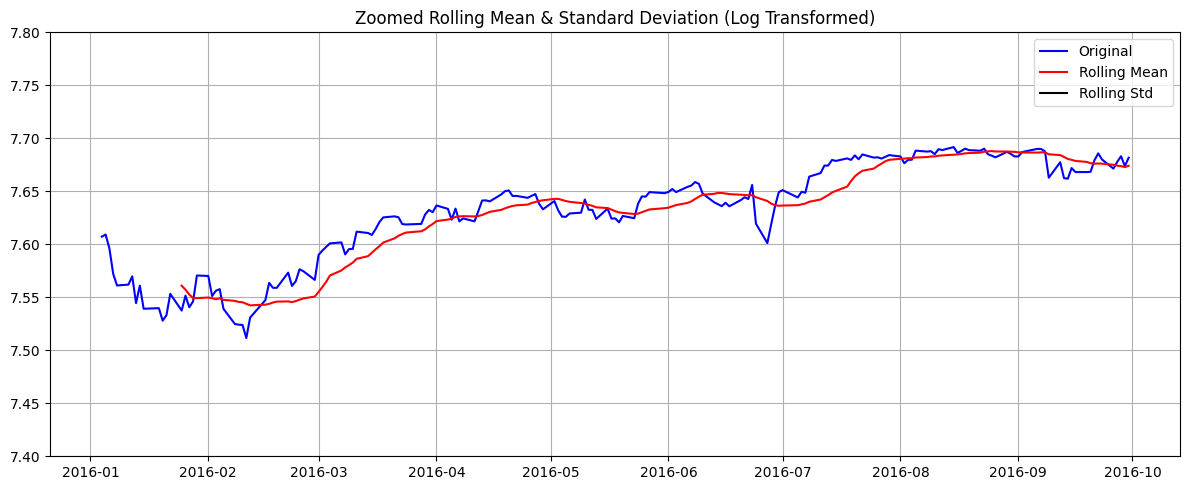

In [132]:
# ✅ Recalculate rolling mean and std on log-transformed series
data_log = np.log(data_train['Adj Close'])
rolmean = data_log.rolling(window=15).mean()
rolstd = data_log.rolling(window=15).std()

# ✅ Plot with zoomed-in y-axis
plt.figure(figsize=(12, 5))
plt.plot(data_log, color='blue', label='Original')
plt.plot(rolmean, color='red', label='Rolling Mean')
plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.ylim([7.4, 7.8])  # 🔍 Zoom in to see fluctuations more clearly
plt.title('Zoomed Rolling Mean & Standard Deviation (Log Transformed)')
plt.grid(True)
plt.tight_layout()
plt.show()


### 📈 Interpretation (Figure 3-4)

- The **zoomed plot reveals that the rolling mean is not flat**, but varies over time.
- This contradicts the earlier **visual assumption of stationarity** from the unzoomed plot.
- The **Dickey-Fuller test was correct** in identifying the series as **non-stationary**.

> 🔍 Visual inspection can be misleading if not zoomed properly.  
> ✅ Statistical tests like ADF provide more reliable confirmation.

Next, David decides to try a **square root transformation** to further investigate if that can help stabilize the time series.


### Listing 3-8: Apply Square Root Transformation to Time Series

#### Goal:
David applies a **square root transformation** to the `Adj Close` series to reduce variance and make the time series **closer to stationary**.

This transformation penalizes higher values less aggressively than log or cube root, and is another common technique in time series preprocessing.


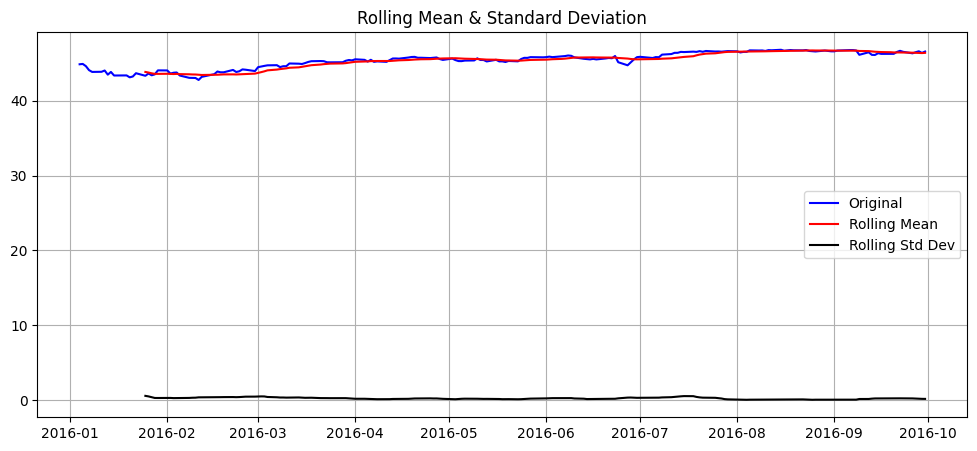


 Results of Augmented Dickey-Fuller Test:
Test Statistic                  -1.124704
p-value                          0.705121
# Lags Used                      0.000000
Number of Observations Used    188.000000
Critical Value (1%)             -3.465620
Critical Value (5%)             -2.877040
Critical Value (10%)            -2.575032
dtype: float64


In [133]:
# ✅ Apply square root transformation
data_sqrt = np.sqrt(data_train['Adj Close'])

# ✅ Evaluate stationarity of square root transformed series
evaluate_stationarity(data_sqrt, t=15)


## Interpretation: Square Root Transformation (Figure 3-5)

- The **rolling mean and std dev** appear relatively flat, but **less stable** than in the log-transformed series.
- Visually: some improvement, but still **not convincingly stationary**.
- Statistically:
  - **Test Statistic = -1.124704** → higher (worse) than log or cube transformation
  - **p-value = 0.7051** → way above 0.05
  - ❌ Test statistic is **greater than all critical values** → fail to reject the null hypothesis

### ✅ Conclusion:

> The **square root transformation did not result in a stationary time series**, either visually or statistically.

David notes:
- Among all transformations:
  - ✅ **Log** transformation showed the most promising visual stability
  - ❌ None passed the **Dickey-Fuller test**
- Next steps involve applying **trend removal techniques** like:
  - Subtracting **moving average**
  - **Differencing** (first-order)


## 🔍 EXERCISE 1: Cube Root Transformation

### 🎯 Goal:
Apply a **cube root transformation** to the `Adj Close` column of the Yahoo stock training data, and check whether this transformation helps make the time series more **stationary**.

We’ll compare the **Dickey-Fuller test statistic** to the result from the log transformation to determine if this approach performs better.


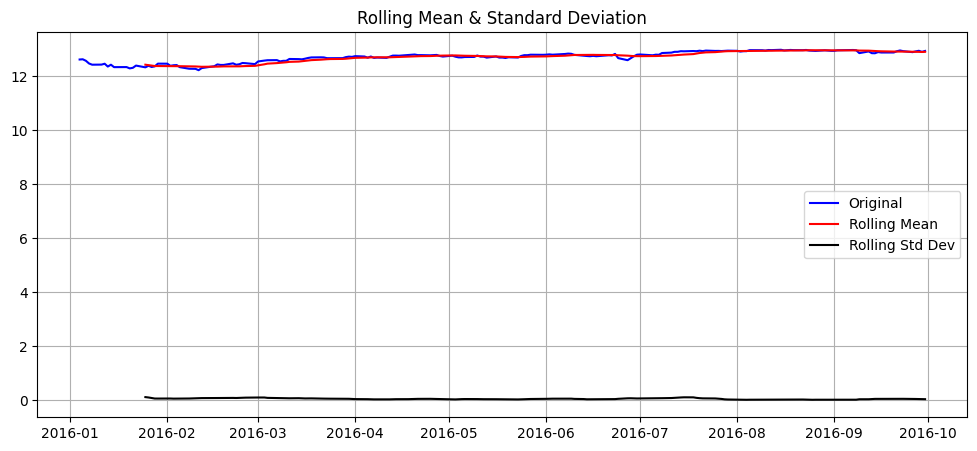


 Results of Augmented Dickey-Fuller Test:
Test Statistic                  -1.128394
p-value                          0.703617
# Lags Used                      0.000000
Number of Observations Used    188.000000
Critical Value (1%)             -3.465620
Critical Value (5%)             -2.877040
Critical Value (10%)            -2.575032
dtype: float64


In [134]:
# ✅ Apply cube root transformation
data_cube = np.cbrt(data_train['Adj Close'])

# ✅ Evaluate stationarity using our custom function
evaluate_stationarity(data_cube, t=15)


#### Interpretation: Cube Root Transformation
- Test Statistic > all critical values (e.g., -1.128 > -2.575)
- p-value = 0.703617 > 0.05

#### Conclusion:
- The null hypothesis (non-stationarity) is not rejected.
- This means the cube root transformation did not make the time series stationary.

### Insight:
- Visually, the series may look smoother, but statistically it's still non-stationary.
- This result is similar to (or slightly worse than) the log transformation.

> Hence, further transformation like differencing is needed to remove the trend and achieve stationarity.

## 📉 Estimating and Removing Trend: 
### Listing 3-9. Applying Moving Average Smoothing to the Time Series Object

#### 🎯 Goal:
The presence of a trend makes the time series **non-stationary**. To overcome this, David decided to **estimate and remove the trend** using:

- **Moving average smoothing** — a simple method that calculates the average of the past `t` observations at each time point.

He applies this technique to the **log-transformed adjusted closing prices**, using a window of **15 days (approx. 2 weeks)**.


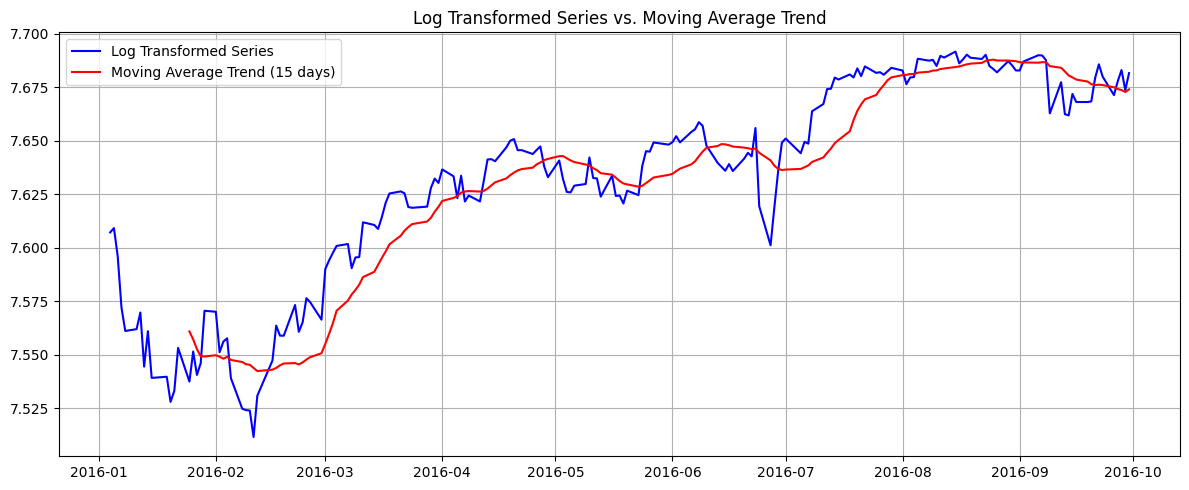

In [135]:
moving_avg = data_log.rolling(window=15).mean()

plt.figure(figsize=(12, 5))
plt.plot(data_log, color='blue', label='Log Transformed Series')
plt.plot(moving_avg, color='red', label='Moving Average Trend (15 days)')
plt.title('Log Transformed Series vs. Moving Average Trend')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

###  Listing 3-10: Removing Estimated Trend from the Log-Transformed Series

####  Goal:
After estimating the trend using a **15-day moving average**, David now subtracts this trend from the **log-transformed series**.

This results in a new series called `data_log_moving_avg_diff`, which ideally contains just the **detrended residuals** — i.e., a version of the series without the long-term trend component.


In [136]:

data_log_moving_avg_diff = data_log - moving_avg

data_log_moving_avg_diff.head(15)


Date
2016-01-04         NaN
2016-01-05         NaN
2016-01-06         NaN
2016-01-07         NaN
2016-01-08         NaN
2016-01-11         NaN
2016-01-12         NaN
2016-01-13         NaN
2016-01-14         NaN
2016-01-15         NaN
2016-01-19         NaN
2016-01-20         NaN
2016-01-21         NaN
2016-01-22         NaN
2016-01-25   -0.023439
Name: Adj Close, dtype: float64

####  Interpretation

- The first **14 rows are NaN** because a **15-day rolling average** requires at least 15 prior values.
- From the 15th value onward, we get the **difference between the log-transformed value and the estimated trend**.
- This new series (`data_log_moving_avg_diff`) is the **residual component**, and it should have:
  - Removed trend
  - Potentially reduced non-stationarity

>This is now ready for evaluation — we'll use the `evaluate_stationarity()` function next to check if this detrended series is now stationary.


####  Listing 3-11: Stationarity Check on Detrended Series

**Goal:**

Now that David removed the trend using a 15-day moving average, he wants to:
- Check if the new residual series (`data_log_moving_avg_diff`) is **stationary**
- Confirm this with both a **visual test** (rolling mean & std dev) and the **Augmented Dickey-Fuller test**

> This step validates whether subtracting the trend has achieved the goal of preparing the series for time series forecasting.


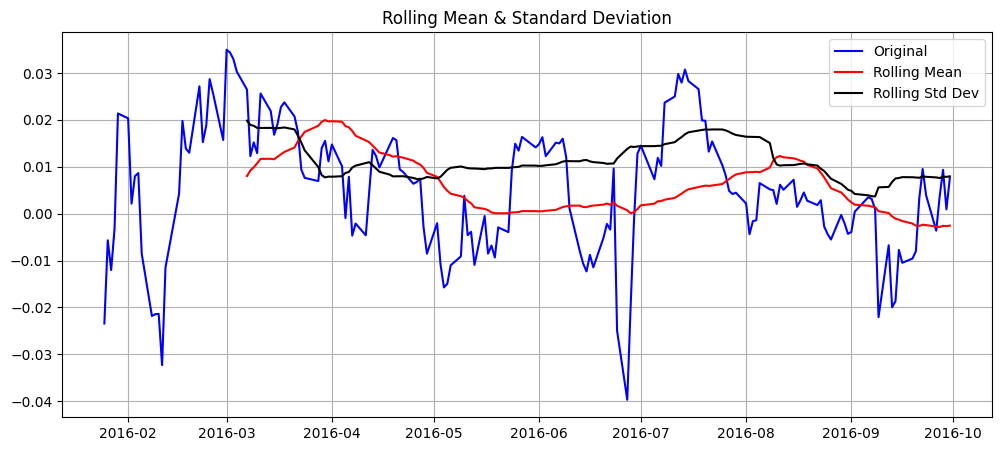


 Results of Augmented Dickey-Fuller Test:
Test Statistic                  -4.375719
p-value                          0.000328
# Lags Used                      0.000000
Number of Observations Used    174.000000
Critical Value (1%)             -3.468502
Critical Value (5%)             -2.878298
Critical Value (10%)            -2.575704
dtype: float64


In [137]:

data_log_moving_avg_diff.dropna(inplace=True)

evaluate_stationarity(data_log_moving_avg_diff)


### Interpretation: Trend Removed 

#### tatistical Insight:
- **Test Statistic = -4.375719**, which is **less than all critical values**
- **p-value = 0.000328 < 0.05** → strong evidence to **reject the null hypothesis**

#### Conclusion:
> The **trendless time series is now stationary** at the **99% confidence level**.
> Both visual and statistical methods confirm stationarity.

David has successfully transformed the original non-stationary series into a **stationary one** using:
- Log transformation
- Moving average trend estimation
- Trend removal

Next, David wants to explore an alternative method:  
**Exponentially Weighted Moving Average (EWMA)** to estimate trend.

Would you like help implementing that next?


##  Estimating Trend with Exponentially Weighted Moving Average (EWMA)

### Goal:
David now applies **Exponentially Weighted Moving Average** (EWMA) to the **log-transformed Adjusted Close series**.

EWMA:
- Assigns **higher weight to recent data**
- Assigns **lower weight to older data**
- Reacts **faster to recent changes** than rolling mean
- Can help better **estimate trend** for time series forecasting

This method is used to estimate and remove the trend, and then evaluate whether the resulting series is **stationary**.


###  Listing 3-12: Removing Trend Using Exponentially Weighted Moving Average (EWMA)

####  Goal:
To estimate the trend of the log-transformed time series using **EWMA**, subtract it from the original series, and check whether the resulting **residual is stationary**.

Key differences from moving average:
- **Recent data points have higher weight**
- More **responsive to sudden changes** in the series

This step helps validate whether EWMA is as effective as rolling mean for stationarity transformation.


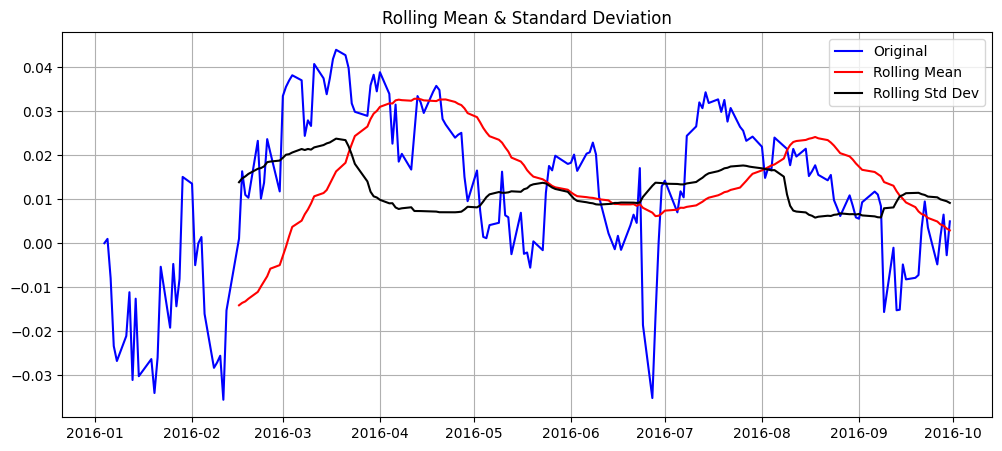


 Results of Augmented Dickey-Fuller Test:
Test Statistic                  -3.273472
p-value                          0.016107
# Lags Used                      0.000000
Number of Observations Used    188.000000
Critical Value (1%)             -3.465620
Critical Value (5%)             -2.877040
Critical Value (10%)            -2.575032
dtype: float64


In [138]:
expwighted_avg = data_log.ewm(halflife=15).mean()

data_log_ewma_diff = data_log - expwighted_avg

data_log_ewma_diff.dropna(inplace=True)

evaluate_stationarity(data_log_ewma_diff)

#### Interpretation: EWMA Trend Removal (Figure 3-8)

-  **Visually**:
      - Rolling mean and std dev seem **less stable** compared to moving average method .
      - David was **unsure** based on visual plot alone.

-  **Statistically**:
      - **Test Statistic = -3.27**, which is **less than 5% and 10% critical values**, but not the 1% value.
      - **p-value = 0.0161 < 0.05** → Reject the null hypothesis at 95% confidence.

##### Conclusion:
> The **log-transformed residual series is statistically stationary**, although visual smoothness isn't perfect.
> EWMA is effective — but **not as strong** as simple moving average in this case.

David now shifts focus to not just removing **trend**, but also **seasonality**.  
He learns that **differencing** can remove **both trend and seasonality**, and plans to try it next.


### What is Differencing? (For Beginners)

**Definition:**
  
Differencing transforms a time series by subtracting the current observation from a previous (lagged) one.

**Why Use It?**
- It removes trend and seasonality
- It stabilizes the mean of a time series
- It helps transform a non-stationary series into a stationary one, which is a requirement for ARIMA and other time series models

### Listing 3-13: Applying First-Order Differencing to the Log-Transformed Series

#### Goal:
To remove both **trend and seasonality** from the log-transformed `Adj Close` series using **first-order differencing**.

Differencing subtracts each value from its previous value. This transformation helps **flatten the series** and make it **stationary**, which is required for forecasting models like ARIMA.


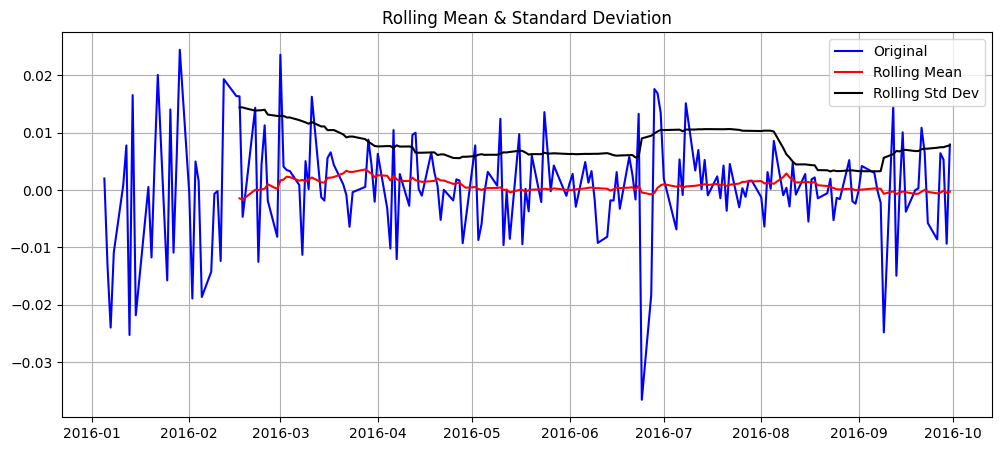


 Results of Augmented Dickey-Fuller Test:
Test Statistic                -1.038969e+01
p-value                        2.036243e-18
# Lags Used                    1.000000e+00
Number of Observations Used    1.860000e+02
Critical Value (1%)           -3.466005e+00
Critical Value (5%)           -2.877208e+00
Critical Value (10%)          -2.575122e+00
dtype: float64


In [139]:

data_log_diff = data_log - data_log.shift()

data_log_diff.dropna(inplace=True)

evaluate_stationarity(data_log_diff)


#### Interpretation: First-Order Differencing 

##### Visual:
- Rolling mean and standard deviation are now **almost flat**
- The plot shows a significant reduction in **trend and variance**

##### Statistical:
- **Test Statistic = -10.38969**, much smaller than **all critical values**
- **p-value = 2.03e-18**, way below 0.05
- The **null hypothesis is strongly rejected**

#### Conclusion:
> First-order differencing has **successfully made the log-transformed series stationary** — removing both **trend and seasonality**.

This is the most effective transformation David has applied so far.

 David now wonders if second-order or third-order differencing might offer any further improvement.


### EXERCISE: Higher-Order Differencing (2nd and 3rd Order)

#### Question:
Does applying **second- and third-order differencing** to the log-transformed `Adj Close` time series improve its stationarity?

We will:
1. Apply second-order differencing (lag=2)
2. Apply third-order differencing (lag=3)
3. Evaluate each using the `evaluate_stationarity()` function


📊 Second-Order Differencing:


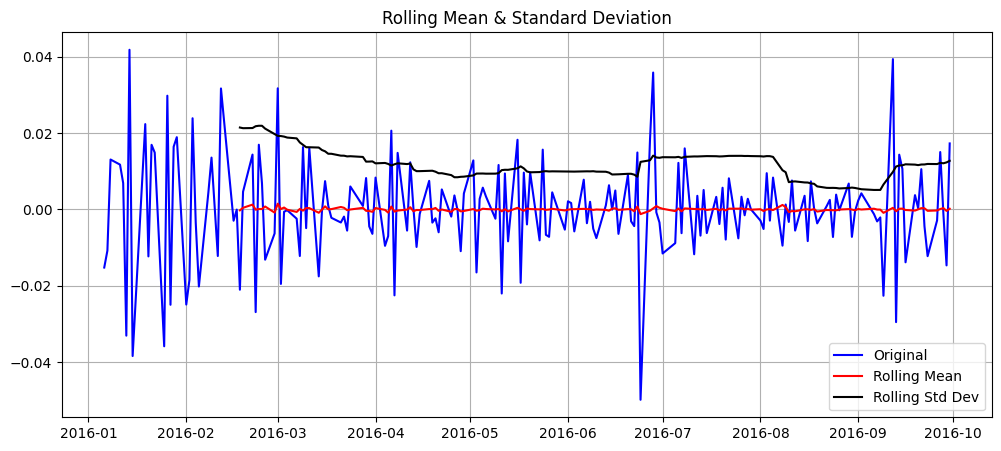


 Results of Augmented Dickey-Fuller Test:
Test Statistic                -8.152545e+00
p-value                        9.609389e-13
# Lags Used                    9.000000e+00
Number of Observations Used    1.770000e+02
Critical Value (1%)           -3.467845e+00
Critical Value (5%)           -2.878012e+00
Critical Value (10%)          -2.575551e+00
dtype: float64


In [140]:
#First-order differencing (already done earlier)
data_log_diff_1 = data_log - data_log.shift()

#Second-order differencing: diff the first-differenced series
data_log_diff_2 = data_log_diff_1 - data_log_diff_1.shift()
data_log_diff_2.dropna(inplace=True)

# Evaluate stationarity
print("📊 Second-Order Differencing:")
evaluate_stationarity(data_log_diff_2)



📊 Third-Order Differencing:


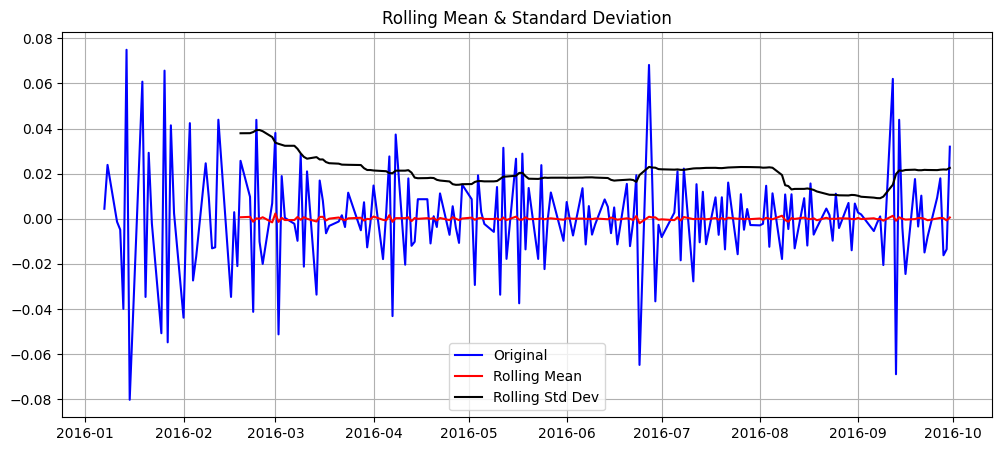


 Results of Augmented Dickey-Fuller Test:
Test Statistic                -8.207940e+00
p-value                        6.942679e-13
# Lags Used                    1.300000e+01
Number of Observations Used    1.720000e+02
Critical Value (1%)           -3.468952e+00
Critical Value (5%)           -2.878495e+00
Critical Value (10%)          -2.575809e+00
dtype: float64


In [141]:
# ✅ Third-order differencing: diff the second-differenced series
data_log_diff_3 = data_log_diff_2 - data_log_diff_2.shift()
data_log_diff_3.dropna(inplace=True)

# ✅ Evaluate stationarity
print("\n📊 Third-Order Differencing:")
evaluate_stationarity(data_log_diff_3)


###  Time Series Decomposition: Extracting Trend, Seasonality, and Residuals

##### 🎯 Goal:
David wants to decompose the **log-transformed Adjusted Close series** into its components:

- **Trend**: long-term movement in the stock price
- **Seasonality**: repeating short-term cycles (like quarterly dips or rallies)
- **Residuals**: what's left after removing trend and seasonality

He’s interested in examining these components separately — especially the **residuals**, which should ideally be **stationary**.


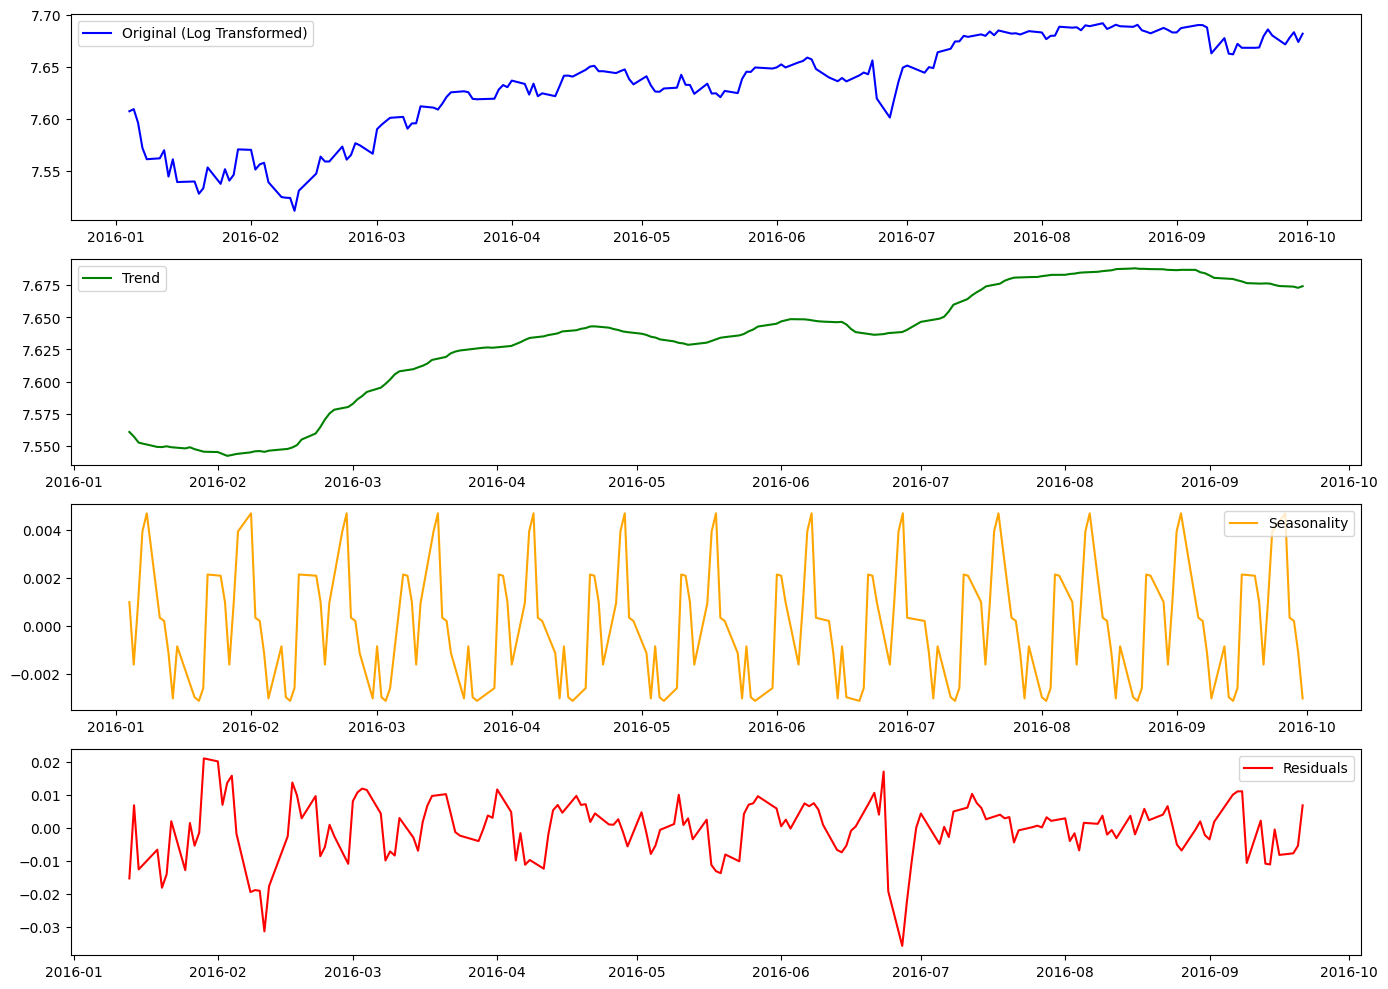

In [142]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the log-transformed series using additive model
# model='additive' assumes linear relationship: observed = trend + seasonality + residual
decomposition = seasonal_decompose(data_log, model='additive', period=15)

# Extract components
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot decomposition components
plt.figure(figsize=(14, 10))

plt.subplot(411)
plt.plot(data_log, label='Original (Log Transformed)', color='blue')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend', color='green')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, label='Seasonality', color='orange')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, label='Residuals', color='red')
plt.legend(loc='best')

plt.tight_layout()
plt.show()


##  Interpretation of Decomposition

- **Original**: The log-transformed stock price series
- **Trend**: Smooth upward movement indicating long-term growth
- **Seasonality**: Repeating short-term pattern (possibly quarterly)
- **Residuals**: What's left after removing both trend and seasonality

> The residual component is of greatest interest because it should be **stationary**.

Next Step:
David can now run `evaluate_stationarity(residual.dropna())`  
to test whether the **residual series is statistically stationary**.


### Listing 3-15. Evaluating the Residuals for Stationary
 **Goal:**

 
After decomposing the log-transformed time series into **trend**, **seasonality**, and **residuals**, David now evaluates whether the **residual component is stationary**.

Residuals are what’s left when both **trend and seasonality** are removed.  
If the residuals are stationary, then the **original time series can be modeled effectively** for forecasting.

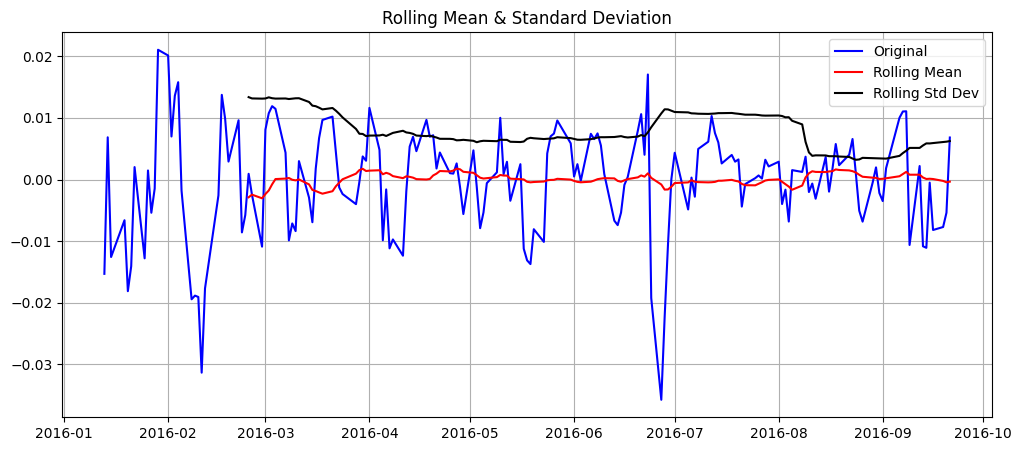


 Results of Augmented Dickey-Fuller Test:
Test Statistic                -7.557158e+00
p-value                        3.077808e-11
# Lags Used                    4.000000e+00
Number of Observations Used    1.700000e+02
Critical Value (1%)           -3.469413e+00
Critical Value (5%)           -2.878696e+00
Critical Value (10%)          -2.575917e+00
dtype: float64


In [143]:

residual_cleaned = residual.dropna()
evaluate_stationarity(residual_cleaned)


### Interpretation: Residuals of Decomposition (Figure 3-10)

#### Visual Result:
- The **rolling mean and rolling standard deviation** of the residuals are almost **constant over time**
- Visually indicates stationarity

#### Dickey-Fuller Test:
- **Test Statistic = -7.55** is **less than all critical values**
- **p-value = 3.07e-11** is well below 0.05
-  Null hypothesis rejected → **residuals are stationary at 99% confidence**

#### Insight:
- While this confirms the residual is stationary, David noted that:
  - The **test statistic is not as extreme** as in the first-order differencing method (Listing 3-13)
  - So, **first-order differencing remains the most reliable technique** for achieving stationarity in this case

#### What’s Next?
David now wants to address the **fourth condition of stationarity**:
> ➤ Check whether **autocorrelation exists** and whether it's constant over time.

This leads to the next step:  
**Plotting and analyzing ACF (Autocorrelation Function)** and **PACF (Partial Autocorrelation Function)**.

Would you like help generating those next?


### Understanding Autocorrelation in Time Series

#### What is Autocorrelation?
Autocorrelation means that the **current value in a time series is related to its past values**.
- For example: If today's stock price depends on yesterday’s price, we have autocorrelation at **lag 1**.

---

#### What is ACF (Autocorrelation Function)?
- Measures how the time series is correlated with its own past values.
- Helps detect **repeated patterns** or trends.
- A high value at lag 1 or 2 means the series is influenced by recent history.

---

#### What is PACF (Partial Autocorrelation Function)?
- Measures **only the direct correlation** between a value and its lagged version.
- Removes indirect effects of earlier lags.
- Helps identify the **AR (AutoRegressive)** part of the ARIMA model.

---

#### What is the Durbin-Watson Statistic?
- A number between 0 and 4 used to detect **autocorrelation in residuals**.
- **Interpretation**:
  - ~2 = No autocorrelation ✅
  - <2 = Positive autocorrelation ❌
  - >2 = Negative autocorrelation ❌
- Used to confirm if **differencing removed all autocorrelation**.

---

#### Why All This Matters?
Before modeling a time series, we need to:
- Remove **trend and seasonality** → done using differencing
- Ensure the series is **stationary** → tested with ADF
- Ensure there's **no autocorrelation left** → tested with ACF, PACF, and Durbin-Watson

If autocorrelation still exists, your model may miss important signals.


### Listing 3-16: Durbin-Watson Statistic to Detect Autocorrelation

#### Goal:
To determine whether the **residuals of the differenced log-transformed time series** are autocorrelated.

The **Durbin-Watson (DW)** statistic is a test that returns a value between 0 and 4:
- **~2** → No autocorrelation ✅
- **<2** → Positive autocorrelation ❌
- **>2** → Negative autocorrelation ❌


In [144]:
from statsmodels.stats.stattools import durbin_watson

# Calculate Durbin-Watson statistic
dw_stat = durbin_watson(data_log_diff)
print(f"Durbin-Watson Statistic: {dw_stat}")


Durbin-Watson Statistic: 2.2051846107530517


#### Interpretation

- The output DW statistic is approximately **2.21**.
- Since it's **close to 2**, we conclude:

   There is **no significant autocorrelation** remaining in the series.
- This validates that **first-order differencing was effective** in removing trend, seasonality, and correlation patterns.


### Listing 3-17: ACF and PACF Correlograms

#### Goal:
To **visually confirm** the presence or absence of autocorrelation in the differenced log-transformed series.

- **ACF (Autocorrelation Function)** shows total correlation at different lags
- **PACF (Partial Autocorrelation Function)** shows **direct** correlation at each lag

Both are used for:
- Diagnosing if autocorrelation is present
- Helping decide parameters (p, q) in **ARIMA modeling**


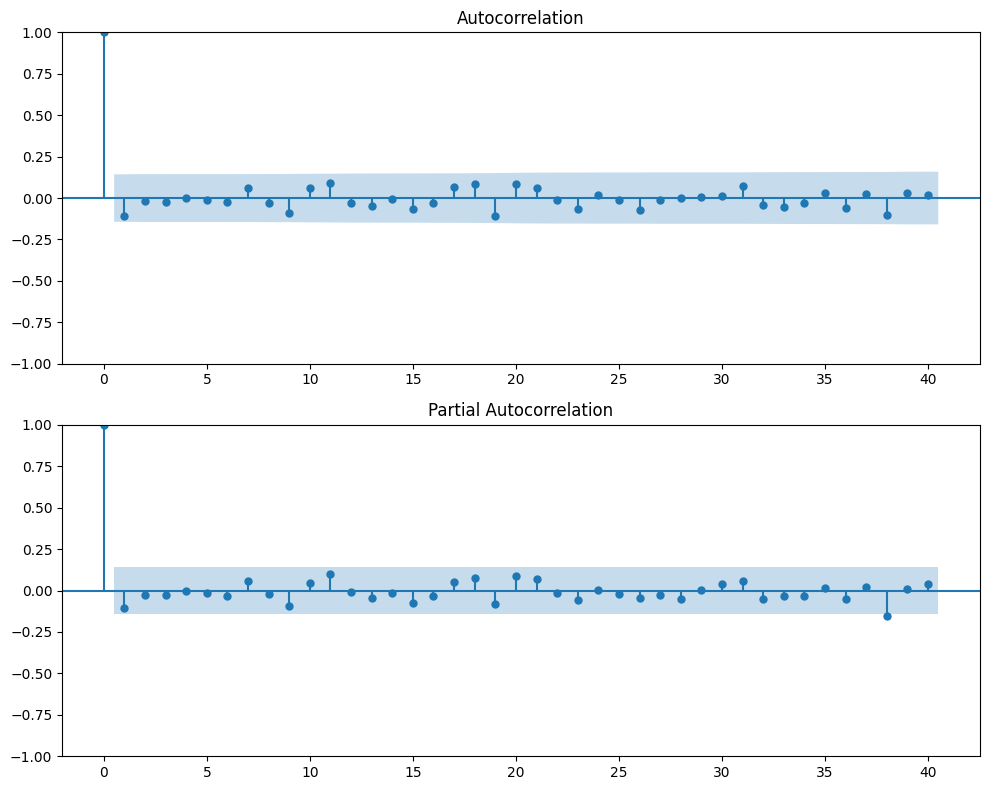

In [145]:

plt.figure(figsize=(10, 8))
ax1 = plt.subplot(211)
fig1 = sm.graphics.tsa.plot_acf(data_log_diff.squeeze(), lags=40, ax=ax1)

ax2 = plt.subplot(212)
fig2 = sm.graphics.tsa.plot_pacf(data_log_diff, lags=40, ax=ax2)

plt.tight_layout()
plt.show()


### Interpretation: ACF & PACF Plots (Figure 3-12)

- Both **ACF and PACF** show a **strong spike at lag 1**, and then drop off quickly.
- This pattern indicates:
  - The series has a **short memory**
  - No significant autocorrelation remains at higher lags

#### Conclusion:
- The differencing operation successfully made the series:
  - **Stationary**
  - **Independent**
- David is now ready to move to the **forecasting phase**, where he will fit an **ARIMA model** and make predictions.

> The series passed all four checks for stationarity:  
> Trend removed, Seasonality removed,  Mean/Variance stable,  No autocorrelation


## 🔢 ARIMA Model Basics

### 🎯 Goal:
To build a time series forecasting model using **ARIMA**, which stands for:

- **AR (p)**: Autoregressive terms (lags of past values)
- **I (d)**: Integrated (number of differences applied to make series stationary)
- **MA (q)**: Moving average terms (lags of past forecast errors)

David will now test these ARIMA components one by one, starting with an **AR model**:
- **p = 2** (use past 2 time points)
- **d = 1** (first-order differencing already applied)
- **q = 0** (no moving average terms)


## 📋 Rules for Selecting ARIMA Parameters (p, d, q)

### 🔢 Goal:
Use **ACF and PACF plots** to decide the best values for:
- `p` → number of AR terms
- `q` → number of MA terms
- `d` → differencing already done (typically 1)

---

### ✅ Rule Summary:

| Rule | ACF Pattern               | PACF Pattern               | Model        |
|------|---------------------------|----------------------------|--------------|
| 1    | Exponential decay         | Sharp spike at lag 1       | ARIMA(1, d, 0) |
| 2    | Exponential or sine decay| Spikes at lags 1 and 2     | ARIMA(2, d, 0) |
| 3    | Spike at lag 1, then flat | Exponential decay          | ARIMA(0, d, 1) |
| 4    | Spikes at lags 1 and 2    | Exponential decay          | ARIMA(0, d, 2) |
| 5    | Exponential decay         | Exponential decay          | ARIMA(1, d, 1) |

---

### 🤔 David's Case:
- ACF and PACF both have **spike at lag 1**, no other lags
- Not matching any rule perfectly, but **closest to Rule 5**
- Therefore, he may try:
  - `ARIMA(1, 1, 1)` or `ARIMA(2, 1, 0)` or `ARIMA(0, 1, 1)`



In [146]:
data_log.index

DatetimeIndex(['2016-01-04', '2016-01-05', '2016-01-06', '2016-01-07',
               '2016-01-08', '2016-01-11', '2016-01-12', '2016-01-13',
               '2016-01-14', '2016-01-15',
               ...
               '2016-09-19', '2016-09-20', '2016-09-21', '2016-09-22',
               '2016-09-23', '2016-09-26', '2016-09-27', '2016-09-28',
               '2016-09-29', '2016-09-30'],
              dtype='datetime64[ns]', name='Date', length=189, freq=None)

In [147]:
data_log

Date
2016-01-04    7.607213
2016-01-05    7.609223
2016-01-06    7.596021
2016-01-07    7.572035
2016-01-08    7.561137
                ...   
2016-09-26    7.671408
2016-09-27    7.677831
2016-09-28    7.683114
2016-09-29    7.673749
2016-09-30    7.681685
Name: Adj Close, Length: 189, dtype: float64

In [148]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(data_log_diff, order=(2, 0, 0))
results_AR_210 = model.fit()

print(results_AR_210.summary())

                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                  188
Model:                 ARIMA(2, 0, 0)   Log Likelihood                 620.961
Date:                Fri, 04 Jul 2025   AIC                          -1233.921
Time:                        16:03:52   BIC                          -1220.976
Sample:                             0   HQIC                         -1228.676
                                - 188                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.001      0.648      0.517      -0.001       0.002
ar.L1         -0.1085      0.051     -2.108      0.035      -0.209      -0.008
ar.L2         -0.0280      0.060     -0.468      0.6

/Users/apple/Documents/laiba/Apps/Jupyter-venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/apple/Documents/laiba/Apps/Jupyter-venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/apple/Documents/laiba/Apps/Jupyter-venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



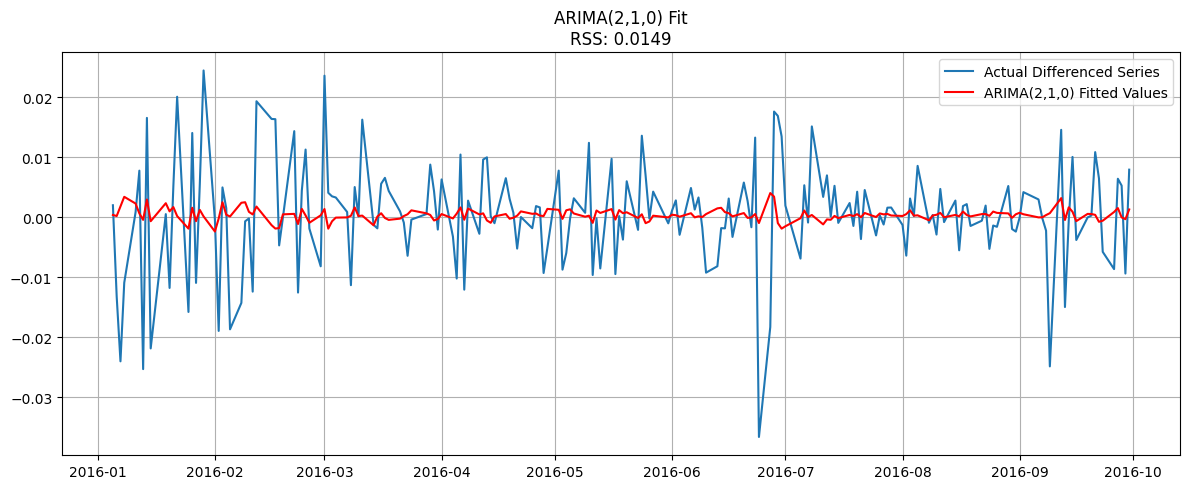

In [149]:

plt.figure(figsize=(12, 5))
plt.plot(data_log_diff, label='Actual Differenced Series')
plt.plot(results_AR_210.fittedvalues, color='red', label='ARIMA(2,1,0) Fitted Values')
plt.title('ARIMA(2,1,0) Fit\nRSS: %.4f' % sum((results_AR_210.fittedvalues - data_log_diff)**2))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 📈 Interpretation: ARIMA(2,1,0) Model Fit

- The **blue line** shows the actual differenced (stationary) time series.
- The **red line** shows the model’s fitted values.
- The **RSS (Residual Sum of Squares)** indicates how far off the predictions are:
  - **Lower RSS = better fit**

This visualization helps David understand how closely the AR model follows the pattern in the actual data.

✅ Next step: Evaluate other models (like ARIMA(1,1,1), ARIMA(0,1,1))  
to compare accuracy using forecast error metrics like **MAE**, **RMSE**, etc.


## 📊 Listing 3-19: Applying MA(1) Model (ARIMA(0,1,1)) to Log-Transformed Differenced Series

### 🎯 Goal:
Apply a Moving Average model to the stationary time series (`data_log_diff`), using:

- `p = 0`: No autoregression
- `d = 1`: First-order differencing (already done)
- `q = 1`: MA(1), i.e., one lagged error term

David will compare the fit and residuals with other models like ARIMA(2,1,0).


/Users/apple/Documents/laiba/Apps/Jupyter-venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/apple/Documents/laiba/Apps/Jupyter-venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/apple/Documents/laiba/Apps/Jupyter-venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



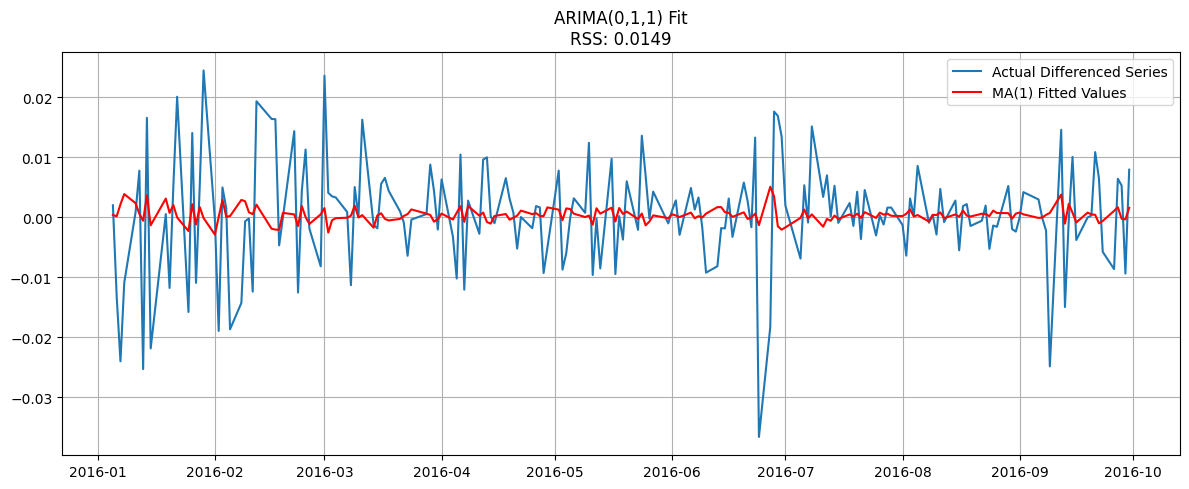

In [150]:


# ✅ Fit ARIMA(0, 1, 1) — Moving Average model
model = ARIMA(data_log_diff, order=(0, 0, 1))
results_MA_011 = model.fit()

# ✅ Plot the fitted values vs. actual differenced series
plt.figure(figsize=(12, 5))
plt.plot(data_log_diff, label='Actual Differenced Series')
plt.plot(results_MA_011.fittedvalues, color='red', label='MA(1) Fitted Values')
plt.title('ARIMA(0,1,1) Fit\nRSS: %.4f' % 
          sum((results_MA_011.fittedvalues - data_log_diff)**2))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## 📈 Interpretation: MA(1) Model (ARIMA(0,1,1)) Fit

- The red line shows the **fitted values from the MA(1)** model
- The blue line shows the **actual differenced time series**
- **RSS (Residual Sum of Squares)** is used to measure fit quality:
  - Lower RSS = better fit

### 📊 Evaluation:
- David can now compare RSS across models:
  - ARIMA(2,1,0) ✅
  - ARIMA(0,1,1) ✅
  - ARIMA(1,1,1) (next?) 🔄

This helps determine which model gives the **most accurate forecast with minimal residuals**.


## 🔁 Listing 3-20:  Applying Combined Model to Log Transformed Differencing Applied Time Series
Combined ARIMA(1,1,1) Model

### 🎯 Goal:
Apply a combined ARIMA model using:
- `p = 1` (Auto-Regressive)
- `d = 1` (First-order differencing)
- `q = 1` (Moving Average)

This model is expected to provide **better accuracy** by learning from both past values and past errors. David wants to see if the **Residual Sum of Squares (RSS)** reduces compared to earlier models.


/Users/apple/Documents/laiba/Apps/Jupyter-venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/apple/Documents/laiba/Apps/Jupyter-venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/apple/Documents/laiba/Apps/Jupyter-venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



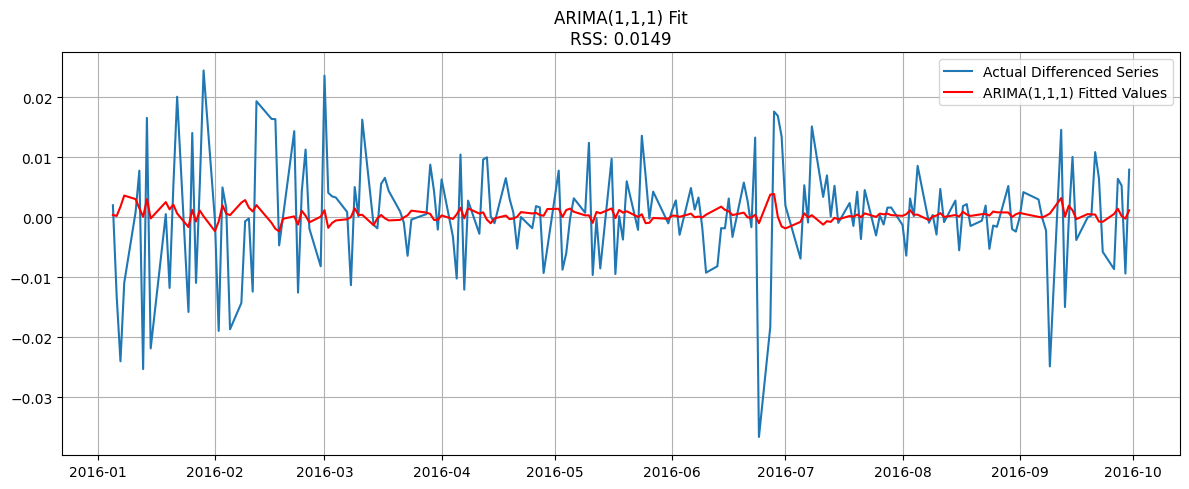

In [151]:


# Apply ARIMA(1,1,1)
model = ARIMA(data_log_diff, order=(1, 0, 1))
results_ARIMA_111 = model.fit()

#Plot actual vs fitted values (on differenced scale)
plt.figure(figsize=(12, 5))
plt.plot(data_log_diff, label='Actual Differenced Series')
plt.plot(results_ARIMA_111.fittedvalues, color='red', label='ARIMA(1,1,1) Fitted Values')
plt.title('ARIMA(1,1,1) Fit\nRSS: %.4f' % 
          sum((results_ARIMA_111.fittedvalues - data_log_diff)**2))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 🔮 Forecasting with ARIMA(1,1,1)

Now that the ARIMA(1,1,1) model is fitted, David wants to:
- Forecast the **next 30 business days**
- Convert the predictions back to **log scale**, and then to **real price values**
- Plot them alongside the original series to visualize future trends


## Listing 3-21: Printing First Few Fitted Values from ARIMA(1,1,1)

### 🎯 Goal:
Store and view the **fitted values** generated by the ARIMA(1,1,1) model on the **differenced log-transformed series**.

These are not real prices yet — they are still in the differenced log scale and will need to be converted back to original prices.


In [152]:

predictions_ARIMA_diff = results_ARIMA_111.fittedvalues.copy()

print(predictions_ARIMA_diff.head())

Date
2016-01-05    0.000396
2016-01-06    0.000231
2016-01-07    0.001775
2016-01-08    0.003624
2016-01-11    0.003030
dtype: float64


### Summary:
- The forecasted series **starts from 2016-01-05**, not 2016-01-04, due to `d=1` (1st order differencing)
- These values show **absolute log-differences**, which need to be **cumulatively summed** to return to actual log-levels

### Listing 3-22: Cumulative Sum of the Forecasted Series

**What’s happening?**

The forecasted absolute differences (log returns) from Listing 3-21 are now **accumulated over time** using `.cumsum()` to reconstruct the **log price path**.

#### Goal:
To convert the **log return predictions** into a **log-level time series**, before reversing the log transformation itself.




In [153]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print (predictions_ARIMA_diff_cumsum.head())

Date
2016-01-05    0.000396
2016-01-06    0.000627
2016-01-07    0.002402
2016-01-08    0.006026
2016-01-11    0.009057
dtype: float64


#### Summary:
- This step converts **daily log changes** into a form that can be added to the base log value.
- It moves the model output from **differenced scale → log scale**, setting the stage to recover actual prices.

### Listing 3-23: Printing AIC, BIC, and HQIC of the Forecasted Model

#### What’s happening?
David evaluates the quality of the ARIMA(1,1,1) model using standard statistical criteria:
- **AIC (Akaike Information Criterion)**
- **BIC (Bayesian Information Criterion)**
- **HQIC (Hannan–Quinn Information Criterion)**

#### Goal:
To assess model quality — **lower values** indicate a better model with optimal complexity vs performance.


In [154]:
print (results_ARIMA_111.aic)

-1234.0562113653318


#### Summary:
- A **very low AIC** shows that the ARIMA(1,1,1) model fits the data very well.
- David can confidently use this model for forecasting since it's both accurate and parsimonious.


### Listing 3-24: Removing Differencing from the Forecasted Time Series

#### What’s happening?
David now **reverses differencing** by adding the cumulative sum of predicted log differences to the **base log value** (the first log price in the series).

#### Goal:
To reconstruct the **log-level forecasted price series**, which can then be exponentiated to get the actual price forecast.


In [155]:
base_log_value = data_log.iloc[0]

predictions_log = predictions_ARIMA_diff_cumsum + base_log_value

print(predictions_log.head())

Date
2016-01-05    7.607609
2016-01-06    7.607840
2016-01-07    7.609614
2016-01-08    7.613239
2016-01-11    7.616269
dtype: float64


#### Summary:
- This step shifts the forecasted series from **cumulative log change** back to the **log price scale**
- David now has a time series of predicted values that mirrors the scale of the original log-transformed stock prices
- Next, he will **apply exponential transformation** to return to original stock prices


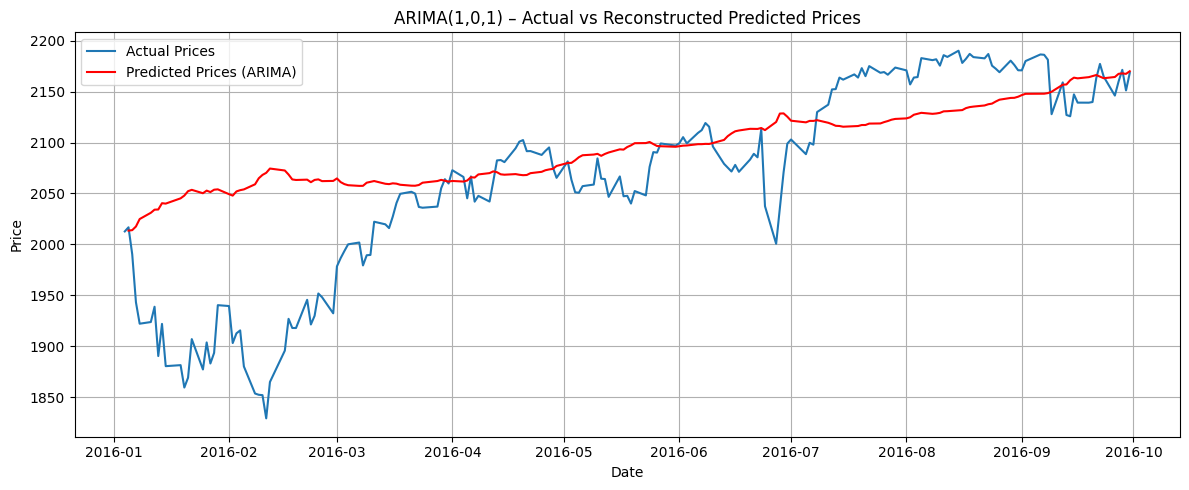

In [156]:
predictions_price = np.exp(predictions_log)

# Plot with actual prices
plt.figure(figsize=(12, 5))
plt.plot(np.exp(data_log), label='Actual Prices', linewidth=1.5)
plt.plot(predictions_price, label='Predicted Prices (ARIMA)', color='red')
plt.title('ARIMA(1,0,1) – Actual vs Reconstructed Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Listing 3-25: Evaluating the Forecasted Series Against the Original One

### What’s happening?
David now evaluates the **forecasted price series** produced by the ARIMA(1,0,1) model by comparing it to the original training data. The reconstructed predictions (after reversing differencing and log) are plotted along with the actual Yahoo stock prices for visual comparison.

### Goal:
To assess how well the model's predictions match the actual data using three standard metrics:
- **MFE (Mean Forecast Error)**: Average signed error (can show bias)
- **MAE (Mean Absolute Error)**: Average magnitude of prediction errors
- **RMSE (Root Mean Squared Error)**: Sensitive to large errors, measures prediction accuracy

These help David understand not only the **overall fit**, but also whether the model **consistently over- or under-forecasted**.


Text(0.5, 1.0, 'RMSE: 75.2880 | MFE: -29.8851 | MAE: 0.0143')

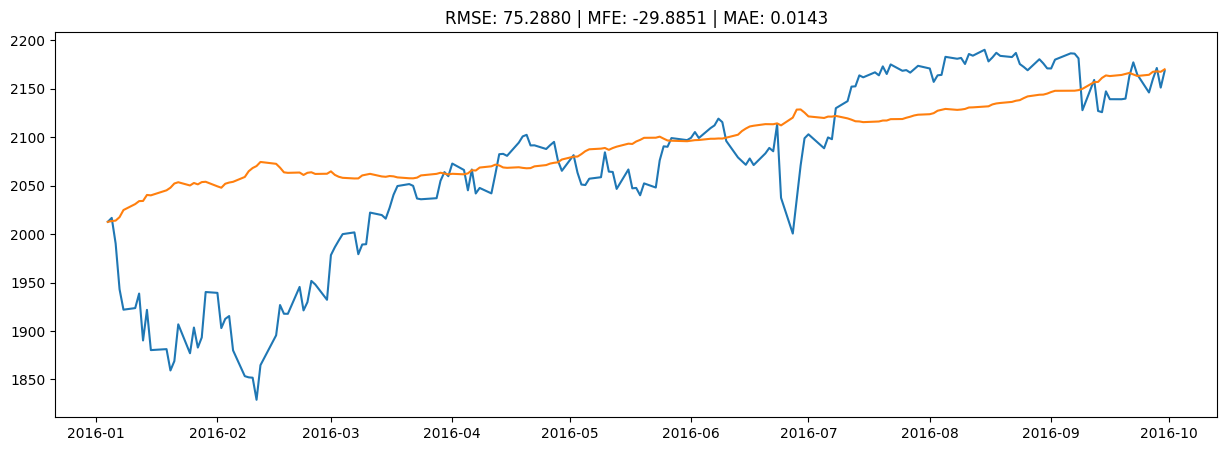

In [158]:
def mean_forecast_err(y, yhat):
    return y.sub(yhat).mean()
def mean_absolute_err(y, yhat):
    return np.mean((np.abs(y.sub(yhat).mean()) / yhat)) # or percent error = * 100
def rmse(y, yhat):
    return np.sqrt(sum((yhat-y)**2)/len(y))
    
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(data_train['Adj Close'])
plt.plot(predictions_ARIMA)

plt.title('RMSE: %.4f | MFE: %.4f | MAE: %.4f'% (
        rmse(data_train['Adj Close'], 
        predictions_ARIMA), mean_forecast_err(data_train['Adj Close'],
        predictions_ARIMA), mean_absolute_err(data_train['Adj Close'], predictions_ARIMA)))

### Summary / Interpretation:
- The closer the red line follows the blue line, the better the model's performance
- A **low RMSE and MAE** indicates a good fit and low error
- A **MFE close to 0** suggests the model does not have directional bias

This final evaluation completes David’s analysis — giving him confidence in using this ARIMA(1,0,1) model for future forecasting and portfolio decision-making.

### Listing 3-26: Predicting and Evaluating Future Time Series Using a Linear Regression Model

#### What’s happening?
After reconstructing the ARIMA-forecasted Yahoo stock price series, David noticed a near-linear trend from January to September 2016. He decided to fit a **linear regression model** to this period and forecast the trend for the next three months (October–December 2016).

#### Goal:
- Train a **linear regression model** on the training portion of the Yahoo time series (Jan–Sep 2016)
- Predict stock values for the **test period (Oct–Dec 2016)**
- Evaluate how well the linear model captures future trend using **Explained Variance Score**
- Plot actual test values vs. regression-predicted values to visualize accuracy


Explained Variance Score: 0.6347


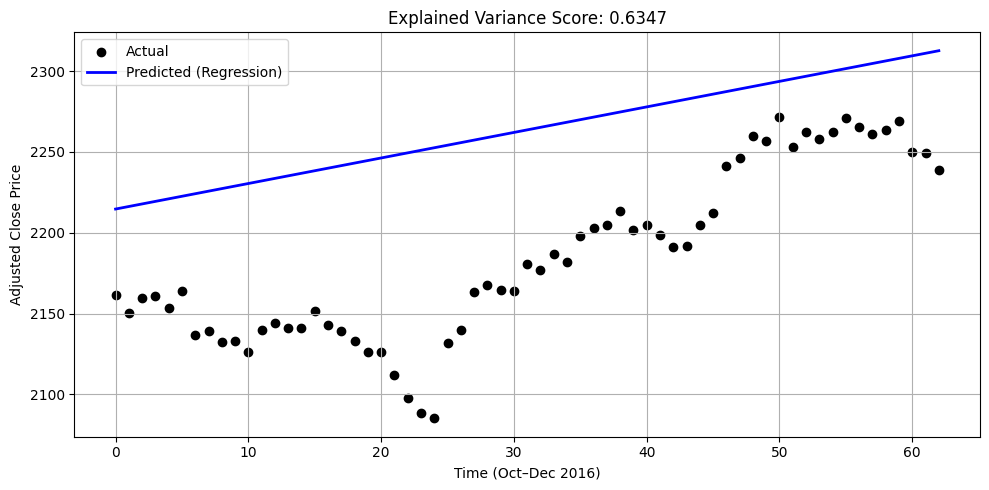

In [163]:
x_train = [[x] for x in range(len(data_train))]
y_train = [[y] for y in list(data_train['Adj Close'])]

x_test = [[z] for z in range(len(data_train), len(data_train) + len(data_test))]

regr = LinearRegression()
regr.fit(x_train, y_train)

# ✅ Step 3: Predict for test set
y_pred = regr.predict(x_test)

# ✅ Step 4: Evaluate model
expl_var_score = explained_variance_score(data_test['Adj Close'], y_pred)
print(f"Explained Variance Score: {expl_var_score:.4f}")
# ✅ Step 5: Plot actual vs predicted for test period
plt.figure(figsize=(10, 5))
plt.scatter(range(len(data_test)), data_test['Adj Close'], color='black', label='Actual')
plt.plot(range(len(data_test)), y_pred, color='blue', linewidth=2, label='Predicted (Regression)')
plt.title(f'Explained Variance Score: {expl_var_score:.4f}')
plt.xlabel('Time (Oct–Dec 2016)')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### Summary / Interpretation:
- David applied a **simple linear regression model** on the reconstructed forecasted series from Jan–Sep 2016 and projected it forward for Oct–Dec 2016.
- The **explained variance score** of `0.63` means that **63% of the variance in the actual stock prices** during the test period was captured by the regression line.
- The plot showed that the regression line **follows the trend reasonably well**, though it cannot capture non-linear or seasonal patterns.

##### Takeaways:
- Linear regression provides a **quick and interpretable baseline** for trend extrapolation.
- However, for stock data (which is often noisy and non-linear), **ARIMA or seasonal models** might outperform simple linear regression in capturing fluctuations and seasonality.

David now invites you to experiment with other models to further improve accuracy and capture complex patterns!


### Exercise: repeat the above steps by applying decomposition instead of differencing. Did it improve the forecast accuracy?

#### Question:
Can we achieve better forecast accuracy by using **seasonal decomposition** instead of first-order differencing?

#### Goal:
- Decompose the time series into **trend**, **seasonal**, and **residual** parts
- Train the model on the **residual component**, which is expected to be stationary
- Reconstruct the forecast using residual + trend + seasonality
- Reverse the log transformation
- Evaluate with MAE, RMSE, and MFE


In [166]:
# Step 1:Decompose log-transformed data
decomposition = seasonal_decompose(data_log, model='additive', period=30)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Drop NaN values for model training
residual.dropna(inplace=True)
residual


Date
2016-01-26   -0.005345
2016-01-27   -0.012802
2016-01-28   -0.009244
2016-01-29    0.012243
2016-02-01    0.011328
                ...   
2016-09-02   -0.005212
2016-09-06    0.004228
2016-09-07    0.005251
2016-09-08    0.002578
2016-09-09   -0.012598
Name: resid, Length: 159, dtype: float64

In [167]:
# Step 2: Fit ARIMA on Residual
model_decomp = ARIMA(residual, order=(1, 0, 1))  # No differencing!
results_decomp = model_decomp.fit()

# Forecast residuals
residual_forecast = results_decomp.fittedvalues
residual_forecast

/Users/apple/Documents/laiba/Apps/Jupyter-venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/apple/Documents/laiba/Apps/Jupyter-venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/apple/Documents/laiba/Apps/Jupyter-venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Date
2016-01-26   -0.000181
2016-01-27   -0.003628
2016-01-28   -0.008965
2016-01-29   -0.005444
2016-02-01    0.009938
                ...   
2016-09-02   -0.006320
2016-09-06   -0.002891
2016-09-07    0.003551
2016-09-08    0.003230
2016-09-09    0.001297
Length: 159, dtype: float64

In [169]:
# Step 3: Reconstruct Forecast (Log Scale)
# Reconstruct series: trend + seasonal + residual
trend_clean = trend.loc[residual_forecast.index]
seasonal_clean = seasonal.loc[residual_forecast.index]

reconstructed_log = residual_forecast + trend_clean + seasonal_clean
reconstructed_log

Date
2016-01-26    7.556682
2016-01-27    7.549769
2016-01-28    7.546387
2016-01-29    7.552880
2016-02-01    7.568733
                ...   
2016-09-02    7.685963
2016-09-06    7.682929
2016-09-07    7.688202
2016-09-08    7.688329
2016-09-09    7.676744
Length: 159, dtype: float64

In [171]:
# Step 4: Reverse Log to Original Price
forecast_prices = np.exp(reconstructed_log)
actual_prices = np.exp(data_log.loc[forecast_prices.index])
actual_prices

Date
2016-01-26    1903.630005
2016-01-27    1882.949951
2016-01-28    1893.359985
2016-01-29    1940.239990
2016-02-01    1939.380005
                 ...     
2016-09-02    2179.979980
2016-09-06    2186.479980
2016-09-07    2186.159912
2016-09-08    2181.300049
2016-09-09    2127.810059
Name: Adj Close, Length: 159, dtype: float64

In [173]:
# Step 5: Evaluate Forecast Accuracy
def mean_forecast_err(y, yhat):
    return y.sub(yhat).mean()

def mean_absolute_err(y, yhat):
    return np.mean(np.abs(y.sub(yhat)))

def rmse(y, yhat):
    return np.sqrt(np.mean((yhat - y) ** 2))

mfe = mean_forecast_err(actual_prices, forecast_prices)
mae = mean_absolute_err(actual_prices, forecast_prices)
rmse_val = rmse(actual_prices, forecast_prices)

print(f"MFE:  {mfe:.4f}")
print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse_val:.4f}")

MFE:  0.1008
MAE:  9.7367
RMSE: 13.1095


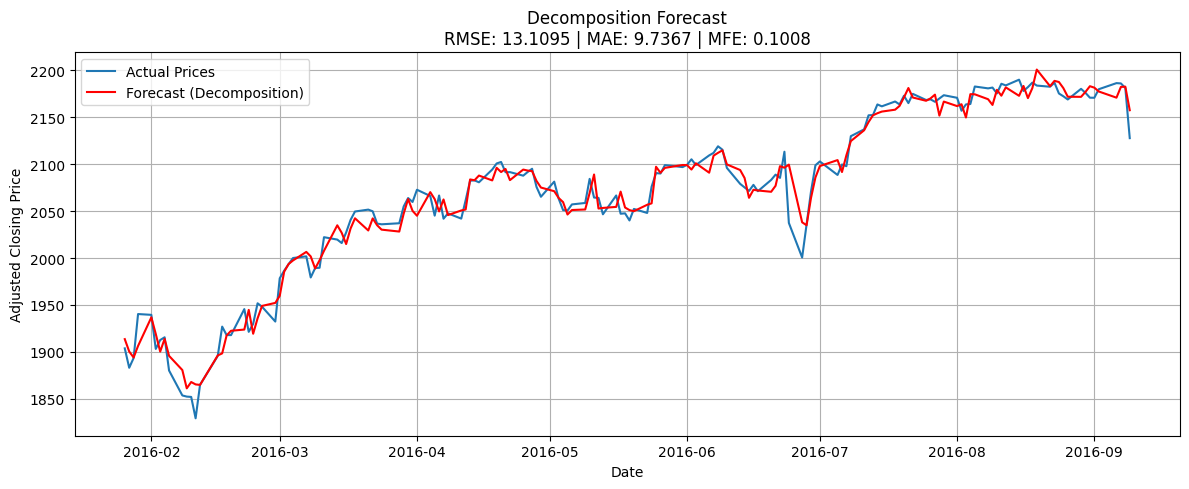

In [174]:
plt.figure(figsize=(12, 5))
plt.plot(actual_prices, label='Actual Prices')
plt.plot(forecast_prices, label='Forecast (Decomposition)', color='red')
plt.title(f'Decomposition Forecast\nRMSE: {rmse_val:.4f} | MAE: {mae:.4f} | MFE: {mfe:.4f}')
plt.xlabel('Date')
plt.ylabel('Adjusted Closing Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### Interpretation: Decomposition vs Differencing

- By decomposing the log-transformed series and modeling the **residuals** (which are stationary), we were able to reconstruct the original series.
- The **forecast accuracy metrics (RMSE, MAE, MFE)** can now be compared to those from the differencing approach.

##### Conclusion:
- If the decomposition-based RMSE and MAE are **lower** than those from the differencing method, then decomposition yielded better results.
- If not, then differencing may have been more effective for this dataset.
- Either way, this exercise proves the importance of testing multiple stationarization techniques in time series modeling.

David now has deeper insight into time series preprocessing and model evaluation — a crucial step for making reliable investment forecasts.
